In [1]:
#!pip install bandmat
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fdm import derivative_matrix, backward_euler, trapezoids
from fdm_integrals import backward_euler_int, trapezoids_int
from FEM import backward_euler_fem, trapezoids_fem
from fem_integrals import backward_euler_fem_int, trapezoids_fem_int
from numerical_integral import compute_integral
from rates import make_b, make_sigma2
from params import ex_params_1

# Metoda różnic skończonych

## MRS: Przykładowe wyniki

In [2]:
n = 100
h = ex_params_1.n_star/n
m = 5000
width = 50
tau = width/m
b = make_b(ex_params_1)
sigma2 = make_sigma2(ex_params_1)
d_m, special = derivative_matrix(b, sigma2, h, n)
u_0 = np.ones(n)
extent=[0, width, 0, 20]

### Zamknięty schemat Eulera

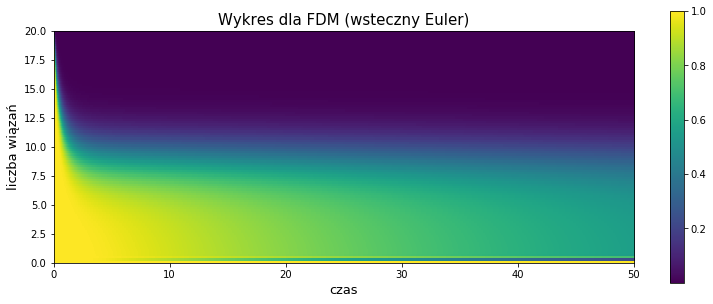

In [3]:
u_beul = backward_euler(u_0, d_m, tau, m)
plt.figure(figsize=(13, 5))
plt.imshow(u_beul.T, origin="low", extent=extent)
plt.colorbar()
plt.title("Wykres dla FDM (wsteczny Euler)", fontsize=15)
plt.xlabel("czas", fontsize=13)
plt.ylabel("liczba wiązań", fontsize=13);

### Schemat trapezów

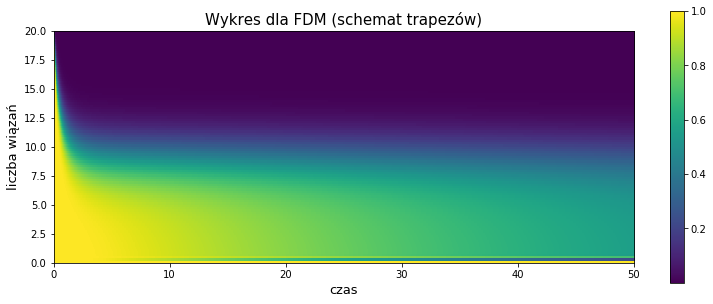

In [4]:
u_trapz = trapezoids(u_0, d_m, special, tau, m)
plt.figure(figsize=(13, 5))
plt.imshow(u_trapz.T, origin="low", extent=extent)
plt.colorbar()
plt.title("Wykres dla FDM (schemat trapezów)", fontsize=15)
plt.xlabel("czas", fontsize=13)
plt.ylabel("liczba wiązań", fontsize=13);

## MRS: Badanie rzędu zbieżności

In [5]:
tol = 10**-5  # tolerancja w całkowaniu funkcji u
kawalki = (20, 40, 80, 160, 320) # Liczba podziałów odcinka [0, 1]
kroki = ("1/20", "1/40", "1/80", "1/160", "1/320")

### Zamknięty schemat Eulera

In [29]:
# Liczymy wartość oczekiwaną z dokładnością 10x większą niż największa liczba kawałków
big_n = int(ex_params_1.n_star * kawalki[-1])
small_h = ex_params_1.n_star / big_n
int_n = 10 * big_n
int_step = small_h / 10
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)
bledy_fdm = np.empty((len(kawalki), len(kawalki)))
bledy1_fdm = np.empty((len(kawalki), len(kawalki)))
for i, kawalki_przestrzen in enumerate(kawalki):
    for j, kawalki_czas in enumerate(kawalki):
        n = int(ex_params_1.n_star * kawalki_przestrzen)
        h = ex_params_1.n_star / n
        tau = 1 / kawalki_czas
        u_0 = np.ones(n)
        d_m, special = derivative_matrix(b, sigma2, h, n)
        int_u_euler = backward_euler_int(u_0, d_m, tau, tol)[1:]
        pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_euler)+1)[1:]  # +1 bo obcięliśmy linijkę wyżej

        # Wycinanie odpowiednich wartości z E
        obetnij_pierwsze = int(int_n/n) - 1
        bierz_co = int(int_n/n)
        linspace = num_int_linspace[obetnij_pierwsze::bierz_co][:-1]
        assert np.allclose(pde_linspace, linspace)  # sprawdzamy czy wszystko OK
        
        bledy_fdm[i,j] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][:-1]-int_u_euler))
        bledy1_fdm[i,j] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][int(kawalki_przestrzen/2):-1]-int_u_euler[int(kawalki_przestrzen/2):]))

Zakończono całkowanie w momencie 942.5500000000001, po 18851 iteracji.
Zakończono całkowanie w momencie 942.375, po 37695 iteracji.
Zakończono całkowanie w momencie 942.2875, po 75383 iteracji.
Zakończono całkowanie w momencie 942.2375000000001, po 150758 iteracji.
Zakończono całkowanie w momencie 942.215625, po 301509 iteracji.
Zakończono całkowanie w momencie 937.5500000000001, po 18751 iteracji.
Zakończono całkowanie w momencie 937.375, po 37495 iteracji.
Zakończono całkowanie w momencie 937.2750000000001, po 74982 iteracji.
Zakończono całkowanie w momencie 937.2375000000001, po 149958 iteracji.
Zakończono całkowanie w momencie 937.2125000000001, po 299908 iteracji.
Zakończono całkowanie w momencie 934.6, po 18692 iteracji.
Zakończono całkowanie w momencie 934.45, po 37378 iteracji.
Zakończono całkowanie w momencie 934.35, po 74748 iteracji.
Zakończono całkowanie w momencie 934.3000000000001, po 149488 iteracji.
Zakończono całkowanie w momencie 934.278125, po 298969 iteracji.
Zakońc

Cały przedział - błędy

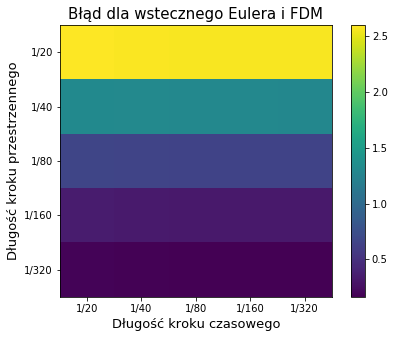

In [66]:
plt.figure(figsize=(7, 5))
plt.imshow(bledy_fdm)
plt.colorbar()
plt.title("Błąd dla wstecznego Eulera i FDM", fontsize=15)
plt.xticks(range(len(kawalki)), kroki)
plt.yticks(range(len(kawalki)), kroki)
plt.xlabel("Długość kroku czasowego", fontsize=13)
plt.ylabel("Długość kroku przestrzennego", fontsize=13);

In [49]:
#kolumna odpowiada krokowi czasowemu
tab_fdm = pd.DataFrame(data=bledy_fdm, index=["h=1/20", "h=1/40", "h=1/80", "h=1/160", "h=1/320"], 
                       columns=["\u03C4=1/20", "\u03C4=1/40", "\u03C4=1/80", "\u03C4=1/160", "\u03C4=1/320"]) 
tab_fdm
#tab_fdm.to_latex()

,τ=1/20,τ=1/40,τ=1/80,τ=1/160,τ=1/320
h=1/20,2.600060,2.587273,2.580879,2.577663,2.576065
h=1/40,1.319991,1.307345,1.301003,1.297851,1.296265
h=1/80,0.673860,0.661305,0.655009,0.651860,0.650289
h=1/160,0.349686,0.337149,0.330886,0.327749,0.326182
h=1/320,0.187295,0.174776,0.168514,0.165384,0.163819


Cały przedział - zbieżnosć schematu względem przestrzeni

In [57]:
tab_fdm_x = tab_fdm.copy()
tab_fdm_x["e(1/20,2h)/e(1/20,h)"] = [0]+[bledy_fdm[i-1,0]/bledy_fdm[i,0] for i in range(1,5)]
tab_fdm_x["e(1/40,2h)/e(1/40,h)"] = [0]+[bledy_fdm[i-1,1]/bledy_fdm[i,1] for i in range(1,5)]
tab_fdm_x["e(1/80,2h)/e(1/80,h)"] = [0]+[bledy_fdm[i-1,2]/bledy_fdm[i,2] for i in range(1,5)]
tab_fdm_x["e(1/160,2h)/e(1/160,h)"] = [0]+[bledy_fdm[i-1,3]/bledy_fdm[i,3] for i in range(1,5)]
tab_fdm_x["e(1/320,2h)/e(1/320,h)"] = [0]+[bledy_fdm[i-1,4]/bledy_fdm[i,4] for i in range(1,5)]
tab_fdm_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)",
           "e(1/320,2h)/e(1/320,h)"]]
#tab_fdm_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"]].to_latex()

,"e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"
h=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
h=1/40,1.969756,1.979029,1.983762,1.986102,1.987298
h=1/80,1.958852,1.976916,1.986237,1.990995,1.993369
h=1/160,1.927041,1.961461,1.979562,1.988902,1.993639
h=1/320,1.867038,1.929035,1.963545,1.981750,1.991114


Cały przedział - zbieżnosć schematu względem czasu

In [55]:
tab_fdm_t = tab_fdm.T
tab_fdm_t["e(2t,1/20)/e(t,1/20)"] = [0]+[bledy_fdm[0,i-1]/bledy_fdm[0,i] for i in range(1,5)]
tab_fdm_t["e(2t,1/40)/e(t,1/40)"] = [0]+[bledy_fdm[1,i-1]/bledy_fdm[1,i] for i in range(1,5)]
tab_fdm_t["e(2t,1/80)/e(t,1/80)"] = [0]+[bledy_fdm[2,i-1]/bledy_fdm[2,i] for i in range(1,5)]
tab_fdm_t["e(2t,1/160)/e(t,1/160)"] = [0]+[bledy_fdm[3,i-1]/bledy_fdm[3,i] for i in range(1,5)]
tab_fdm_t["e(2t,1/320)/e(t,1/320)"] = [0]+[bledy_fdm[4,i-1]/bledy_fdm[4,i] for i in range(1,5)]
tab_fdm_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)",
           "e(2t,1/320)/e(t,1/320)"]]
#tab_fem_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"]].to_latex()

,"e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"
τ=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
τ=1/40,1.004942,1.009673,1.018984,1.037185,1.071626
τ=1/80,1.002477,1.004875,1.009613,1.018930,1.037158
τ=1/160,1.001247,1.002429,1.004830,1.009570,1.018931
τ=1/320,1.000620,1.001223,1.002417,1.004804,1.009552


Przedział [0,5, 20] - błędy

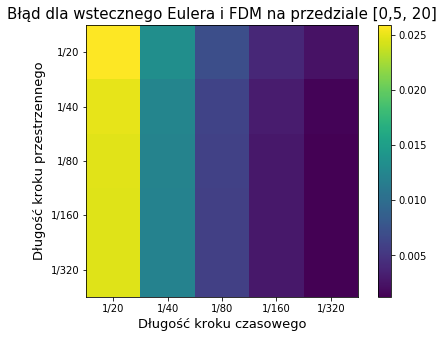

In [67]:
plt.figure(figsize=(7, 5))
plt.imshow(bledy1_fdm)
plt.colorbar()
plt.title("Błąd dla wstecznego Eulera i FDM na przedziale [0,5, 20]", fontsize=15)
plt.xticks(range(len(kawalki)), kroki)
plt.yticks(range(len(kawalki)), kroki)
plt.xlabel("Długość kroku czasowego", fontsize=13)
plt.ylabel("Długość kroku przestrzennego", fontsize=13);

In [32]:
tab_fdm1 = pd.DataFrame(data=bledy1_fdm, index=["h=1/20", "h=1/40", "h=1/80", "h=1/160", "h=1/320"], 
                       columns=["\u03C4=1/20", "\u03C4=1/40", "\u03C4=1/80", "\u03C4=1/160", "\u03C4=1/320"]) 
tab_fdm1

,τ=1/20,τ=1/40,τ=1/80,τ=1/160,τ=1/320
h=1/20,0.025889,0.013390,0.007140,0.004014,0.002452
h=1/40,0.024963,0.012463,0.006213,0.003088,0.001525
h=1/80,0.024751,0.012251,0.006001,0.002876,0.001313
h=1/160,0.024696,0.012196,0.005946,0.002821,0.001258
h=1/320,0.024681,0.012181,0.005931,0.002806,0.001243


Przedział [0,5, 20] - zbieżność schematu względem przestrzeni

In [54]:
tab_fdm1_x = tab_fdm1.copy()
tab_fdm1_x["e(1/20,2h)/e(1/20,h)"] = [0]+[bledy1_fdm[i-1,0]/bledy1_fdm[i,0] for i in range(1,5)]
tab_fdm1_x["e(1/40,2h)/e(1/40,h)"] = [0]+[bledy1_fdm[i-1,1]/bledy1_fdm[i,1] for i in range(1,5)]
tab_fdm1_x["e(1/80,2h)/e(1/80,h)"] = [0]+[bledy1_fdm[i-1,2]/bledy1_fdm[i,2] for i in range(1,5)]
tab_fdm1_x["e(1/160,2h)/e(1/160,h)"] = [0]+[bledy1_fdm[i-1,3]/bledy1_fdm[i,3] for i in range(1,5)]
tab_fdm1_x["e(1/320,2h)/e(1/320,h)"] = [0]+[bledy1_fdm[i-1,4]/bledy1_fdm[i,4] for i in range(1,5)]
tab_fdm1_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)",
           "e(1/320,2h)/e(1/320,h)"]]
#tab_fdm_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"]].to_latex()

,"e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"
h=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
h=1/40,1.037130,1.074369,1.149191,1.300168,1.607692
h=1/80,1.008561,1.017288,1.035294,1.073664,1.161294
h=1/160,1.002237,1.004537,1.009290,1.019583,1.043903
h=1/320,1.000603,1.001222,1.002527,1.005341,1.012055


Przedział [0,5, 20] - zbieżność względem czasu

In [56]:
tab_fdm1_t = tab_fdm1.T
tab_fdm1_t["e(2t,1/20)/e(t,1/20)"] = [0]+[bledy1_fdm[0,i-1]/bledy1_fdm[0,i] for i in range(1,5)]
tab_fdm1_t["e(2t,1/40)/e(t,1/40)"] = [0]+[bledy1_fdm[1,i-1]/bledy1_fdm[1,i] for i in range(1,5)]
tab_fdm1_t["e(2t,1/80)/e(t,1/80)"] = [0]+[bledy1_fdm[2,i-1]/bledy1_fdm[2,i] for i in range(1,5)]
tab_fdm1_t["e(2t,1/160)/e(t,1/160)"] = [0]+[bledy1_fdm[3,i-1]/bledy1_fdm[3,i] for i in range(1,5)]
tab_fdm1_t["e(2t,1/320)/e(t,1/320)"] = [0]+[bledy1_fdm[4,i-1]/bledy1_fdm[4,i] for i in range(1,5)]
tab_fdm1_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)",
           "e(2t,1/320)/e(t,1/320)"]]
#tab_fem_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"]].to_latex()

,"e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"
τ=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
τ=1/40,1.933566,2.002993,2.020324,2.024962,2.026214
τ=1/80,1.875409,2.006019,2.041526,2.051185,2.053858
τ=1/160,1.778435,2.012079,2.086650,2.107929,2.113846
τ=1/320,1.637236,2.024486,2.189720,2.241952,2.256924


### Schemat trapezów

In [35]:
# Liczymy wartość oczekiwaną z dokładnością 10x większą niż największa liczba kawałków
big_n = int(ex_params_1.n_star * kawalki[-1])
small_h = ex_params_1.n_star / big_n
int_n = 10 * big_n
int_step = small_h / 10
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)
bledy_fdm_tr = np.empty((len(kawalki), len(kawalki)))
bledy1_fdm_tr = np.empty((len(kawalki), len(kawalki)))
for i, kawalki_przestrzen in enumerate(kawalki):
    for j, kawalki_czas in enumerate(kawalki):
        n = int(ex_params_1.n_star * kawalki_przestrzen)
        h = ex_params_1.n_star / n
        tau = 1 / kawalki_czas
        u_0 = np.ones(n)
        d_m, special = derivative_matrix(b, sigma2, h, n)
        int_u_trap = trapezoids_int(u_0, d_m, special, tau, tol)[1:]
        pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_trap)+1)[1:]  # +1 bo obcięliśmy linijkę wyżej

        # Wycinanie odpowiednich wartości z E
        obetnij_pierwsze = int(int_n/n) - 1
        bierz_co = int(int_n/n)
        linspace = num_int_linspace[obetnij_pierwsze::bierz_co][:-1]
        assert np.allclose(pde_linspace, linspace)  # sprawdzamy czy wszystko OK
        
        bledy_fdm_tr[i,j] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][:-1]-int_u_trap))
        bledy1_fdm_tr[i,j] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][int(kawalki_przestrzen/2):-1]-int_u_trap[int(kawalki_przestrzen/2):]))

Zakończono całkowanie w momencie 942.25, po 18845 iteracji.
Zakończono całkowanie w momencie 942.225, po 37689 iteracji.
Zakończono całkowanie w momencie 942.2125000000001, po 75377 iteracji.
Zakończono całkowanie w momencie 942.2, po 150752 iteracji.
Zakończono całkowanie w momencie 942.1968750000001, po 301503 iteracji.
Zakończono całkowanie w momencie 937.25, po 18745 iteracji.
Zakończono całkowanie w momencie 937.225, po 37489 iteracji.
Zakończono całkowanie w momencie 937.2125000000001, po 74977 iteracji.
Zakończono całkowanie w momencie 937.2, po 149952 iteracji.
Zakończono całkowanie w momencie 937.19375, po 299902 iteracji.
Zakończono całkowanie w momencie 1384.8500000000001, po 27697 iteracji.
Zakończono całkowanie w momencie 934.3000000000001, po 37372 iteracji.
Zakończono całkowanie w momencie 934.2750000000001, po 74742 iteracji.
Zakończono całkowanie w momencie 934.2625, po 149482 iteracji.
Zakończono całkowanie w momencie 934.2593750000001, po 298963 iteracji.
Zakończono 

Cały przedział - błąd

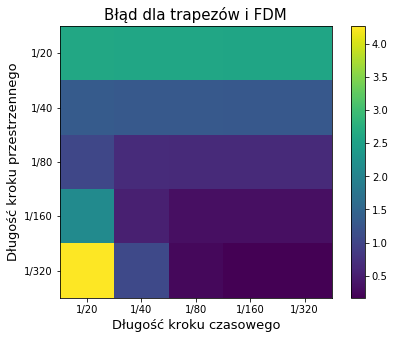

In [68]:
plt.figure(figsize=(7, 5))
plt.imshow(bledy_fdm_tr)
plt.colorbar()
plt.title("Błąd dla trapezów i FDM", fontsize=15)
plt.xticks(range(len(kawalki)), kroki)
plt.yticks(range(len(kawalki)), kroki)
plt.xlabel("Długość kroku czasowego", fontsize=13)
plt.ylabel("Długość kroku przestrzennego", fontsize=13);

In [58]:
#kolumna odpowiada krokowi czasowemu
tab_fdm_tr = pd.DataFrame(data=bledy_fdm_tr, index=["h=1/20", "h=1/40", "h=1/80", "h=1/160", "h=1/320"], 
                       columns=["\u03C4=1/20", "\u03C4=1/40", "\u03C4=1/80", "\u03C4=1/160", "\u03C4=1/320"]) 
tab_fdm_tr
#tab_fdm_tr.to_latex()

,τ=1/20,τ=1/40,τ=1/80,τ=1/160,τ=1/320
h=1/20,2.622955,2.598916,2.586760,2.580622,2.577550
h=1/40,1.343405,1.319248,1.307033,1.300875,1.297783
h=1/80,1.041927,0.673340,0.661085,0.654917,0.651823
h=1/160,2.133864,0.521642,0.336995,0.330822,0.327724
h=1/320,4.269604,1.067685,0.261004,0.168466,0.165366


Cały przedział - zbieżność schematu względem przestrzeni

In [59]:
tab_fdm_tr_x = tab1_fdm_tr.copy()
tab_fdm_tr_x["e(1/20,2h)/e(1/20,h)"] = [0]+[bledy_fdm_tr[i-1,0]/bledy_fdm_tr[i,0] for i in range(1,5)]
tab_fdm_tr_x["e(1/40,2h)/e(1/40,h)"] = [0]+[bledy_fdm_tr[i-1,1]/bledy_fdm_tr[i,1] for i in range(1,5)]
tab_fdm_tr_x["e(1/80,2h)/e(1/80,h)"] = [0]+[bledy_fdm_tr[i-1,2]/bledy_fdm_tr[i,2] for i in range(1,5)]
tab_fdm_tr_x["e(1/160,2h)/e(1/160,h)"] = [0]+[bledy_fdm_tr[i-1,3]/bledy_fdm_tr[i,3] for i in range(1,5)]
tab_fdm_tr_x["e(1/320,2h)/e(1/320,h)"] = [0]+[bledy_fdm_tr[i-1,4]/bledy_fdm_tr[i,4] for i in range(1,5)]
tab_fdm_tr_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)",
           "e(1/320,2h)/e(1/320,h)"]]
#tab_fdm_tr_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"]].to_latex()

,"e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"
h=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
h=1/40,1.952468,1.969998,1.979109,1.983760,1.986118
h=1/80,1.289346,1.959261,1.977101,1.986319,1.991005
h=1/160,0.488282,1.290807,1.961705,1.979665,1.988937
h=1/320,0.499780,0.488574,1.291149,1.963729,1.981812


Cały przedział - zbieżność schematu względem czasu

In [78]:
tab_fdm_tr_t = tab1_fdm_tr.T
tab_fdm_tr_t["e(2t,1/20)/e(t,1/20)"] = [0]+[bledy_fdm_tr[0,i-1]/bledy_fdm_tr[0,i] for i in range(1,5)]
tab_fdm_tr_t["e(2t,1/40)/e(t,1/40)"] = [0]+[bledy_fdm_tr[1,i-1]/bledy_fdm_tr[1,i] for i in range(1,5)]
tab_fdm_tr_t["e(2t,1/80)/e(t,1/80)"] = [0]+[bledy_fdm_tr[2,i-1]/bledy_fdm_tr[2,i] for i in range(1,5)]
tab_fdm_tr_t["e(2t,1/160)/e(t,1/160)"] = [0]+[bledy_fdm_tr[3,i-1]/bledy_fdm_tr[3,i] for i in range(1,5)]
tab_fdm_tr_t["e(2t,1/320)/e(t,1/320)"] = [0]+[bledy_fdm_tr[4,i-1]/bledy_fdm_tr[4,i] for i in range(1,5)]
tab_fdm_tr_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)",
           "e(2t,1/320)/e(t,1/320)"]]
#tab_fdm_tr_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"]].to_latex()

,"e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"
τ=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
τ=1/40,1.009250,1.018311,1.547403,4.090665,3.998937
τ=1/80,1.004699,1.009346,1.018537,1.547922,4.090678
τ=1/160,1.002378,1.004734,1.009418,1.018660,1.549297
τ=1/320,1.001192,1.002382,1.004747,1.009453,1.018749


Przedział [0,5, 20] - błąd

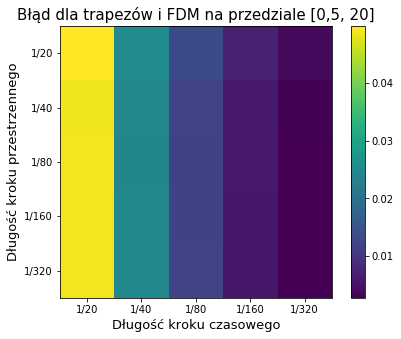

In [69]:
plt.figure(figsize=(7, 5))
plt.imshow(bledy1_fdm_tr)
plt.colorbar()
plt.title("Błąd dla trapezów i FDM na przedziale [0,5, 20]", fontsize=15)
plt.xticks(range(len(kawalki)), kroki)
plt.yticks(range(len(kawalki)), kroki)
plt.xlabel("Długość kroku czasowego", fontsize=13)
plt.ylabel("Długość kroku przestrzennego", fontsize=13);

In [62]:
#kolumna odpowiada krokowi czasowemu
tab_fdm1_tr = pd.DataFrame(data=bledy1_fdm_tr, index=["h=1/20", "h=1/40", "h=1/80", "h=1/160", "h=1/320"], 
                       columns=["\u03C4=1/20", "\u03C4=1/40", "\u03C4=1/80", "\u03C4=1/160", "\u03C4=1/320"]) 
tab_fdm1_tr
#tab_fdm1_tr.to_latex()

,τ=1/20,τ=1/40,τ=1/80,τ=1/160,τ=1/320
h=1/20,0.049834,0.025563,0.013287,0.007107,0.004004
h=1/40,0.048893,0.024629,0.012357,0.006178,0.003077
h=1/80,0.048988,0.024413,0.012143,0.005966,0.002864
h=1/160,0.048936,0.024676,0.012087,0.005910,0.002809
h=1/320,0.048922,0.024664,0.012394,0.005895,0.002794


Przedział [0,5,20] - zbieżność schematu względem przestrzeni

In [63]:
tab_fdm1_tr_x = tab_fdm1_tr.copy()
tab_fdm1_tr_x["e(1/20,2h)/e(1/20,h)"] = [0]+[bledy1_fdm_tr[i-1,0]/bledy1_fdm_tr[i,0] for i in range(1,5)]
tab_fdm1_tr_x["e(1/40,2h)/e(1/40,h)"] = [0]+[bledy1_fdm_tr[i-1,1]/bledy1_fdm_tr[i,1] for i in range(1,5)]
tab_fdm1_tr_x["e(1/80,2h)/e(1/80,h)"] = [0]+[bledy1_fdm_tr[i-1,2]/bledy1_fdm_tr[i,2] for i in range(1,5)]
tab_fdm1_tr_x["e(1/160,2h)/e(1/160,h)"] = [0]+[bledy1_fdm_tr[i-1,3]/bledy1_fdm_tr[i,3] for i in range(1,5)]
tab_fdm1_tr_x["e(1/320,2h)/e(1/320,h)"] = [0]+[bledy1_fdm_tr[i-1,4]/bledy1_fdm_tr[i,4] for i in range(1,5)]
tab_fdm1_tr_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)",
           "e(1/320,2h)/e(1/320,h)"]]
#tab1_fdm_tr_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"]].to_latex()

,"e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"
h=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
h=1/40,1.019248,1.037926,1.075298,1.150293,1.301534
h=1/80,0.998052,1.008827,1.017600,1.035666,1.074118
h=1/160,1.001070,0.989356,1.004648,1.009427,1.019750
h=1/320,1.000292,1.000496,0.975242,1.002579,1.005403


Przedział [0,5,20] - zbieżność schematu względem czasu

In [65]:
tab_fdm1_tr_t = tab_fdm1_tr.T
tab_fdm1_tr_t["e(2t,1/20)/e(t,1/20)"] = [0]+[bledy1_fdm_tr[0,i-1]/bledy1_fdm_tr[0,i] for i in range(1,5)]
tab_fdm1_tr_t["e(2t,1/40)/e(t,1/40)"] = [0]+[bledy1_fdm_tr[1,i-1]/bledy1_fdm_tr[1,i] for i in range(1,5)]
tab_fdm1_tr_t["e(2t,1/80)/e(t,1/80)"] = [0]+[bledy1_fdm_tr[2,i-1]/bledy1_fdm_tr[2,i] for i in range(1,5)]
tab_fdm1_tr_t["e(2t,1/160)/e(t,1/160)"] = [0]+[bledy1_fdm_tr[3,i-1]/bledy1_fdm_tr[3,i] for i in range(1,5)]
tab_fdm1_tr_t["e(2t,1/320)/e(t,1/320)"] = [0]+[bledy1_fdm_tr[4,i-1]/bledy1_fdm_tr[4,i] for i in range(1,5)]
tab_fdm1_tr_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)",
           "e(2t,1/320)/e(t,1/320)"]]
#tab_fdm1_tr_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"]].to_latex()

,"e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"
τ=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
τ=1/40,1.949466,1.985191,2.006623,1.983143,1.983547
τ=1/80,1.923878,1.993150,2.010482,2.041557,1.990027
τ=1/160,1.869562,1.999952,2.035460,2.045141,2.102467
τ=1/320,1.774904,2.008268,2.082830,2.104130,2.110057


# Metoda elementu skończonego

## MES: Przykładowe wyniki

In [21]:
n = 100
h = ex_params_1.n_star/n
m = 5000
width = 50
tau = width/m
b = make_b(ex_params_1)
sigma2 = make_sigma2(ex_params_1)
u_0 = np.ones(n)
extent=[0, width, 0, 20]

### Zamknięty schemat Eulera

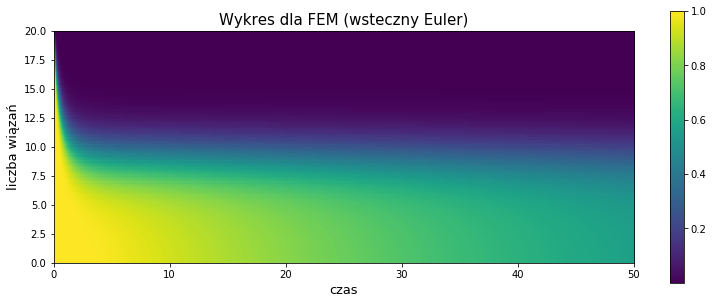

In [11]:
u_fdm_beul = backward_euler_fem(n, h, u_0, tau, m, ex_params_1)
plt.figure(figsize=(13, 5))
plt.imshow(u_fdm_beul.T, origin="low", extent=extent)
plt.colorbar()
plt.title("Wykres dla FEM (wsteczny Euler)", fontsize=15)
plt.xlabel("czas", fontsize=13)
plt.ylabel("liczba wiązań", fontsize=13);

### Schemat trapezów

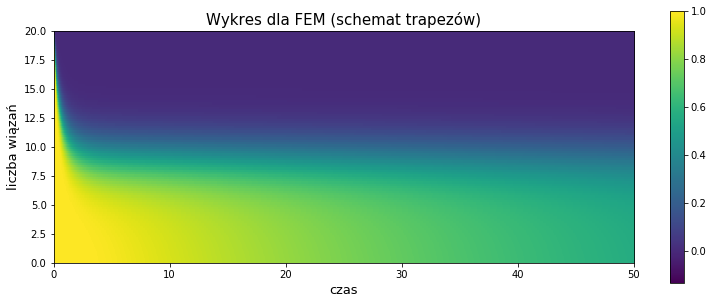

In [13]:
u_fdm_trapz = trapezoids_fem(n, h, u_0, tau, m, ex_params_1)
plt.figure(figsize=(13, 5))
plt.imshow(u_fdm_trapz.T, origin="low", extent=extent)
plt.colorbar()
plt.title("Wykres dla FEM (schemat trapezów)", fontsize=15)
plt.xlabel("czas", fontsize=13)
plt.ylabel("liczba wiązań", fontsize=13);

## MES: Badanie rzędu zbieżności

In [22]:
tol = 10**-5  # tolerancja w całkowaniu funkcji u
kawalki = (20, 40, 80, 160, 320) # Liczba podziałów odcinka [0, 1]
kroki = ("1/20", "1/40", "1/80", "1/160", "1/320")

### Zamknięty schemat Eulera

In [23]:
# Liczymy wartość oczekiwaną z dokładnością 10x większą niż największa liczba kawałków
big_n = int(ex_params_1.n_star * kawalki[-1])
small_h = ex_params_1.n_star / big_n
int_n = 10 * big_n
int_step = small_h / 10
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)
bledy = np.empty((len(kawalki), len(kawalki)))
for i, kawalki_przestrzen in enumerate(kawalki):
    for j, kawalki_czas in enumerate(kawalki):
        n = int(ex_params_1.n_star * kawalki_przestrzen)
        h = ex_params_1.n_star / n
        tau = 1 / kawalki_czas
        u_0 = np.ones(n)
        int_u_euler = backward_euler_fem_int(n, h, u_0, ex_params_1, tau, tol)[1:]
        pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_euler)+1)[1:]  # +1 bo obcięliśmy linijkę wyżej

        # Wycinanie odpowiednich wartości z E
        obetnij_pierwsze = int(int_n/n) - 1
        bierz_co = int(int_n/n)
        linspace = num_int_linspace[obetnij_pierwsze::bierz_co][:-1]
        assert np.allclose(pde_linspace, linspace)  # sprawdzamy czy wszystko OK
        
        bledy[i,j] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][:-1]-int_u_euler))

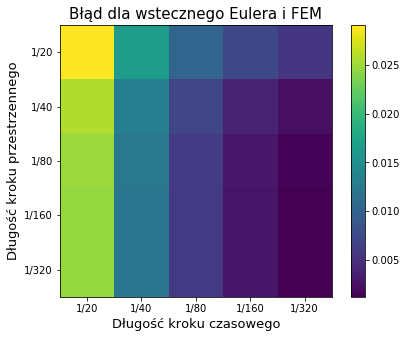

In [73]:
plt.figure(figsize=(7, 5))
plt.imshow(bledy)
plt.colorbar()
plt.title("Błąd dla wstecznego Eulera i FEM", fontsize=15)
plt.xticks(range(len(kawalki)), kroki)
plt.yticks(range(len(kawalki)), kroki)
plt.xlabel("Długość kroku czasowego", fontsize=13)
plt.ylabel("Długość kroku przestrzennego", fontsize=13);

In [75]:
#kolumna odpowiada krokowi czasowemu
tab_fem = pd.DataFrame(data=bledy, index=["h=1/20", "h=1/40", "h=1/80", "h=1/160", "h=1/320"], 
                       columns=["\u03C4=1/20", "\u03C4=1/40", "\u03C4=1/80", "\u03C4=1/160", "\u03C4=1/320"]) 
tab_fem

,τ=1/20,τ=1/40,τ=1/80,τ=1/160,τ=1/320
h=1/20,0.029099,0.016599,0.010349,0.007224,0.005662
h=1/40,0.025759,0.013259,0.007009,0.003884,0.002321
h=1/80,0.024924,0.012424,0.006174,0.003049,0.001487
h=1/160,0.024715,0.012215,0.005965,0.002840,0.001278
h=1/320,0.024663,0.012163,0.005913,0.002788,0.001226


In [26]:
tab_fem_x = tab_fem.copy()
tab_fem_x["e(1/20,2h)/e(1/20,h)"] = [0]+[bledy[i-1,0]/bledy[i,0] for i in range(1,5)]
tab_fem_x["e(1/40,2h)/e(1/40,h)"] = [0]+[bledy[i-1,1]/bledy[i,1] for i in range(1,5)]
tab_fem_x["e(1/80,2h)/e(1/80,h)"] = [0]+[bledy[i-1,2]/bledy[i,2] for i in range(1,5)]
tab_fem_x["e(1/160,2h)/e(1/160,h)"] = [0]+[bledy[i-1,3]/bledy[i,3] for i in range(1,5)]
tab_fem_x["e(1/320,2h)/e(1/320,h)"] = [0]+[bledy[i-1,4]/bledy[i,4] for i in range(1,5)]
tab_fem_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)",
           "e(1/320,2h)/e(1/320,h)"]]
#tab_fem_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"]].to_latex()

,"e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"
h=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
h=1/40,1.129668,1.251931,1.476574,1.860013,2.438879
h=1/80,1.033504,1.067205,1.135238,1.273845,1.561676
h=1/160,1.008445,1.017086,1.034985,1.073490,1.163372
h=1/320,1.002114,1.004288,1.008833,1.018723,1.042533


In [27]:
tab_fem_t = tab_fem.T
tab_fem_t["e(2t,1/20)/e(t,1/20)"] = [0]+[bledy[0,i-1]/bledy[0,i] for i in range(1,5)]
tab_fem_t["e(2t,1/40)/e(t,1/40)"] = [0]+[bledy[1,i-1]/bledy[1,i] for i in range(1,5)]
tab_fem_t["e(2t,1/80)/e(t,1/80)"] = [0]+[bledy[2,i-1]/bledy[2,i] for i in range(1,5)]
tab_fem_t["e(2t,1/160)/e(t,1/160)"] = [0]+[bledy[3,i-1]/bledy[3,i] for i in range(1,5)]
tab_fem_t["e(2t,1/320)/e(t,1/320)"] = [0]+[bledy[4,i-1]/bledy[4,i] for i in range(1,5)]
tab_fem_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)",
           "e(2t,1/320)/e(t,1/320)"]]
#tab_fem_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"]].to_latex()

,"e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"
τ=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
τ=1/40,1.753036,1.942766,2.006116,2.023306,2.027697
τ=1/80,1.603913,1.891714,2.012308,2.047721,2.056988
τ=1/160,1.432575,1.804589,2.024921,2.100255,2.120845
τ=1/320,1.275972,1.673075,2.051113,2.222849,2.274802


### Schemat trapezów

In [43]:
# Liczymy wartość oczekiwaną z dokładnością 10x większą niż największa liczba kawałków
big_n = int(ex_params_1.n_star * kawalki[-1])
small_h = ex_params_1.n_star / big_n
int_n = 10 * big_n
int_step = small_h / 10
num_int_linspace, num_int = compute_integral(int_step, int_n, ex_params_1)
bledy_tr = np.empty((len(kawalki), len(kawalki)))
for i, kawalki_przestrzen in enumerate(kawalki):
    for j, kawalki_czas in enumerate(kawalki):
        n = int(ex_params_1.n_star * kawalki_przestrzen)
        h = ex_params_1.n_star / n
        tau = 1 / kawalki_czas
        u_0 = np.ones(n)
        int_u_euler = trapezoids_fem_int(n, h, u_0, ex_params_1, tau, tol)[1:]
        pde_linspace = np.linspace(0, ex_params_1.n_star-h, len(int_u_euler)+1)[1:]  # +1 bo obcięliśmy linijkę wyżej

        # Wycinanie odpowiednich wartości z E
        obetnij_pierwsze = int(int_n/n) - 1
        bierz_co = int(int_n/n)
        linspace = num_int_linspace[obetnij_pierwsze::bierz_co][:-1]
        assert np.allclose(pde_linspace, linspace)  # sprawdzamy czy wszystko OK
        
        bledy_tr[i,j] = np.mean(np.abs(num_int[obetnij_pierwsze::bierz_co][:-1]-int_u_euler))

Zakończono całkowanie w momencie 927.85, po 18557 iteracji.
Zakończono całkowanie w momencie 927.8000000000001, po 37112 iteracji.
Zakończono całkowanie w momencie 927.7750000000001, po 74222 iteracji.
Zakończono całkowanie w momencie 927.7687500000001, po 148443 iteracji.
Zakończono całkowanie w momencie 927.7625, po 296884 iteracji.
Zakończono całkowanie w momencie 927.75, po 18555 iteracji.
Zakończono całkowanie w momencie 927.7, po 37108 iteracji.
Zakończono całkowanie w momencie 927.6875, po 74215 iteracji.
Zakończono całkowanie w momencie 927.6812500000001, po 148429 iteracji.
Zakończono całkowanie w momencie 927.6750000000001, po 296856 iteracji.
Zakończono całkowanie w momencie 3698.3, po 73966 iteracji.
Zakończono całkowanie w momencie 927.6750000000001, po 37107 iteracji.
Zakończono całkowanie w momencie 927.6625, po 74213 iteracji.
Zakończono całkowanie w momencie 927.65625, po 148425 iteracji.
Zakończono całkowanie w momencie 927.653125, po 296849 iteracji.
Zakończono całko

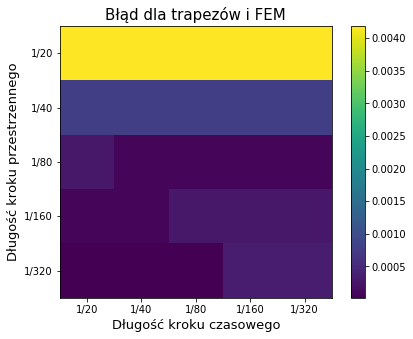

In [76]:
plt.figure(figsize=(7, 5))
plt.imshow(bledy_tr)
plt.colorbar()
plt.title("Błąd dla trapezów i FEM", fontsize=15)
plt.xticks(range(len(kawalki)), kroki)
plt.yticks(range(len(kawalki)), kroki)
plt.xlabel("Długość kroku czasowego", fontsize=13)
plt.ylabel("Długość kroku przestrzennego", fontsize=13);

In [45]:
#kolumna odpowiada krokowi czasowemu
tab_fem_tr = pd.DataFrame(data=bledy_tr, index=["h=1/20", "h=1/40", "h=1/80", "h=1/160", "h=1/320"], 
                       columns=["\u03C4=1/20", "\u03C4=1/40", "\u03C4=1/80", "\u03C4=1/160", "\u03C4=1/320"]) 
tab_fem_tr
#tab_fem_tr.to_latex()

,τ=1/20,τ=1/40,τ=1/80,τ=1/160,τ=1/320
h=1/20,0.004188,0.004188,0.004188,0.004188,0.004188
h=1/40,0.000785,0.000785,0.000785,0.000785,0.000785
h=1/80,0.000284,0.000076,0.000076,0.000076,0.000076
h=1/160,0.000071,0.000071,0.000285,0.000285,0.000285
h=1/320,0.000018,0.000018,0.000018,0.000337,0.000337


In [46]:
tab_fem_tr_x = tab_fem_tr.copy()
tab_fem_tr_x["e(1/20,2h)/e(1/20,h)"] = [0]+[bledy_tr[i-1,0]/bledy_tr[i,0] for i in range(1,5)]
tab_fem_tr_x["e(1/40,2h)/e(1/40,h)"] = [0]+[bledy_tr[i-1,1]/bledy_tr[i,1] for i in range(1,5)]
tab_fem_tr_x["e(1/80,2h)/e(1/80,h)"] = [0]+[bledy_tr[i-1,2]/bledy_tr[i,2] for i in range(1,5)]
tab_fem_tr_x["e(1/160,2h)/e(1/160,h)"] = [0]+[bledy_tr[i-1,3]/bledy_tr[i,3] for i in range(1,5)]
tab_fem_tr_x["e(1/320,2h)/e(1/320,h)"] = [0]+[bledy_tr[i-1,4]/bledy_tr[i,4] for i in range(1,5)]
tab_fem_tr_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)",
           "e(1/320,2h)/e(1/320,h)"]]
#tab_fem_tr_x[["e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"]].to_latex()

,"e(1/20,2h)/e(1/20,h)","e(1/40,2h)/e(1/40,h)","e(1/80,2h)/e(1/80,h)","e(1/160,2h)/e(1/160,h)","e(1/320,2h)/e(1/320,h)"
h=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
h=1/40,5.332660,5.333258,5.333188,5.333189,5.333263
h=1/80,2.769211,10.334773,10.334776,10.334750,10.334599
h=1/160,4.001070,1.071945,0.266901,0.266901,0.266888
h=1/320,4.004644,4.004675,16.083783,0.845036,0.845076


In [47]:
tab_fem_tr_t = tab_fem_tr.T
tab_fem_tr_t["e(2t,1/20)/e(t,1/20)"] = [0]+[bledy_tr[0,i-1]/bledy_tr[0,i] for i in range(1,5)]
tab_fem_tr_t["e(2t,1/40)/e(t,1/40)"] = [0]+[bledy_tr[1,i-1]/bledy_tr[1,i] for i in range(1,5)]
tab_fem_tr_t["e(2t,1/80)/e(t,1/80)"] = [0]+[bledy_tr[2,i-1]/bledy_tr[2,i] for i in range(1,5)]
tab_fem_tr_t["e(2t,1/160)/e(t,1/160)"] = [0]+[bledy_tr[3,i-1]/bledy_tr[3,i] for i in range(1,5)]
tab_fem_tr_t["e(2t,1/320)/e(t,1/320)"] = [0]+[bledy_tr[4,i-1]/bledy_tr[4,i] for i in range(1,5)]
tab_fem_tr_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)",
           "e(2t,1/320)/e(t,1/320)"]]
#tab_fem_tr_t[["e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"]].to_latex()

,"e(2t,1/20)/e(t,1/20)","e(2t,1/40)/e(t,1/40)","e(2t,1/80)/e(t,1/80)","e(2t,1/160)/e(t,1/160)","e(2t,1/320)/e(t,1/320)"
τ=1/20,0.000000,0.000000,0.000000,0.000000,0.000000
τ=1/40,1.000026,1.000138,3.732544,1.000003,1.000011
τ=1/80,1.000013,1.000000,1.000000,0.248988,0.999997
τ=1/160,1.000000,1.000000,0.999998,1.000000,0.052540
τ=1/320,1.000003,1.000017,1.000003,0.999952,1.000000
